In [1]:
from pathlib import Path
import torch
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from lerobot.common.policies.diffusion.configuration_diffusion import DiffusionConfig
from lerobot.common.policies.diffusion.modeling_diffusion import DiffusionPolicy
import numpy as np
import matplotlib.pyplot as plt
import time 
import datetime

/home/ns1254/miniforge3/envs/lerobot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
date

'2024-11-16_20-01'

In [3]:
output_directory = Path("outputs/train/example_lift_diffusion_" + date)
output_directory.mkdir(parents=True, exist_ok=True)

training_steps = 15000
device = torch.device("cuda")
log_freq = 500

In [4]:
# Set up the dataset.
delta_timestamps = {
    # Load the previous image and state at -0.1 seconds before current frame,
    # then load current image and state corresponding to 0.0 second.
    "observation.images.agentview_image": [-0.1, 0.0],
    "observation.images.robot0_eye_in_hand_image": [-0.1, 0.0],
    "observation.robot0_eef_pos": [-0.1, 0.0],
    "observation.robot0_eef_quat": [-0.1, 0.0],
    "observation.robot0_gripper_qpos": [-0.1, 0.0],
    "observation.state": [-0.1, 0.0],
    # Load the previous action (-0.1), the next action to be executed (0.0),
    # and 14 future actions with a 0.1 seconds spacing. All these actions will be
    # used to supervise the policy.
    "action": [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
}
# dataset = LeRobotDataset("lerobot/pusht", delta_timestamps=delta_timestamps)

In [5]:
local_dir = Path("/home/ns1254/lerobot/data") 
dataset = LeRobotDataset(repo_id="lift", root=local_dir, delta_timestamps=delta_timestamps)

In [6]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=4,
    batch_size=64,
    shuffle=True,
    pin_memory=device != torch.device("cpu"),
    drop_last=True,
)

In [7]:
batch = next(iter(dataloader))
for key, value in batch.items():
    print(f"{key}: {value.shape}")

dones: torch.Size([64])
rewards: torch.Size([64])
observation.object: torch.Size([64, 10])
observation.robot0_eef_pos: torch.Size([64, 2, 3])
observation.robot0_eef_quat: torch.Size([64, 2, 4])
observation.robot0_eef_vel_ang: torch.Size([64, 3])
observation.robot0_eef_vel_lin: torch.Size([64, 3])
observation.robot0_gripper_qpos: torch.Size([64, 2, 2])
observation.robot0_gripper_qvel: torch.Size([64, 2])
observation.robot0_joint_pos: torch.Size([64, 7])
observation.robot0_joint_pos_cos: torch.Size([64, 7])
observation.robot0_joint_pos_sin: torch.Size([64, 7])
observation.robot0_joint_vel: torch.Size([64, 7])
observation.state: torch.Size([64, 2, 32])
action: torch.Size([64, 16, 7])
next.done: torch.Size([64])
observation.images.agentview_image: torch.Size([64, 2, 3, 84, 84])
observation.images.robot0_eye_in_hand_image: torch.Size([64, 2, 3, 84, 84])
episode_index: torch.Size([64])
frame_index: torch.Size([64])
timestamp: torch.Size([64])
index: torch.Size([64])
observation.images.agentv

In [8]:
# Set up the the policy.
# Policies are initialized with a configuration class, in this case `DiffusionConfig`.
# For this example, no arguments need to be passed because the defaults are set up for PushT.
# If you're doing something different, you will likely need to change at least some of the defaults.
cfg = DiffusionConfig()

In [9]:
cfg

DiffusionConfig(n_obs_steps=2, horizon=16, n_action_steps=8, input_shapes={'observation.image': [3, 96, 96], 'observation.state': [2]}, output_shapes={'action': [2]}, input_normalization_modes={'observation.image': 'mean_std', 'observation.state': 'min_max'}, output_normalization_modes={'action': 'min_max'}, vision_backbone='resnet18', crop_shape=(84, 84), crop_is_random=True, pretrained_backbone_weights=None, use_group_norm=True, spatial_softmax_num_keypoints=32, use_separate_rgb_encoder_per_camera=False, down_dims=(512, 1024, 2048), kernel_size=5, n_groups=8, diffusion_step_embed_dim=128, use_film_scale_modulation=True, noise_scheduler_type='DDPM', num_train_timesteps=100, beta_schedule='squaredcos_cap_v2', beta_start=0.0001, beta_end=0.02, prediction_type='epsilon', clip_sample=True, clip_sample_range=1.0, num_inference_steps=None, do_mask_loss_for_padding=False)

In [10]:
cfg.input_shapes, cfg.output_shapes

({'observation.image': [3, 96, 96], 'observation.state': [2]}, {'action': [2]})

In [11]:
input_shapes = {'observation.images.agentview_image': (3, 84, 84), 'observation.images.robot0_eye_in_hand_image': (3, 84, 84), 
                'observation.robot0_eef_pos': (3,), 'observation.robot0_eef_quat': (4,), 'observation.robot0_gripper_qpos': (2,),
                'observation.state': (3,)}

output_shapes = {'action': (7,)}

In [12]:
input_shapes

{'observation.images.agentview_image': (3, 84, 84),
 'observation.images.robot0_eye_in_hand_image': (3, 84, 84),
 'observation.robot0_eef_pos': (3,),
 'observation.robot0_eef_quat': (4,),
 'observation.robot0_gripper_qpos': (2,),
 'observation.state': (3,)}

In [13]:
cfg.input_shapes = input_shapes
cfg.output_shapes = output_shapes

In [14]:
print(cfg)

DiffusionConfig(n_obs_steps=2, horizon=16, n_action_steps=8, input_shapes={'observation.images.agentview_image': (3, 84, 84), 'observation.images.robot0_eye_in_hand_image': (3, 84, 84), 'observation.robot0_eef_pos': (3,), 'observation.robot0_eef_quat': (4,), 'observation.robot0_gripper_qpos': (2,), 'observation.state': (3,)}, output_shapes={'action': (7,)}, input_normalization_modes={'observation.image': 'mean_std', 'observation.state': 'min_max'}, output_normalization_modes={'action': 'min_max'}, vision_backbone='resnet18', crop_shape=(84, 84), crop_is_random=True, pretrained_backbone_weights=None, use_group_norm=True, spatial_softmax_num_keypoints=32, use_separate_rgb_encoder_per_camera=False, down_dims=(512, 1024, 2048), kernel_size=5, n_groups=8, diffusion_step_embed_dim=128, use_film_scale_modulation=True, noise_scheduler_type='DDPM', num_train_timesteps=100, beta_schedule='squaredcos_cap_v2', beta_start=0.0001, beta_end=0.02, prediction_type='epsilon', clip_sample=True, clip_samp

In [15]:
input_normalization_mode={
    "observation.images.agentview_image": "mean_std",
    "observation.images.robot0_eye_in_hand_image": "mean_std",
    "observation.robot0_eef_pos": "mean_std",
    "observation.robot0_eef_quat": "mean_std",
    "observation.robot0_gripper_qpos": "mean_std",
    "observation.state": "mean_std",
}
cfg.input_normalization_modes = input_normalization_mode

In [16]:
cfg

DiffusionConfig(n_obs_steps=2, horizon=16, n_action_steps=8, input_shapes={'observation.images.agentview_image': (3, 84, 84), 'observation.images.robot0_eye_in_hand_image': (3, 84, 84), 'observation.robot0_eef_pos': (3,), 'observation.robot0_eef_quat': (4,), 'observation.robot0_gripper_qpos': (2,), 'observation.state': (3,)}, output_shapes={'action': (7,)}, input_normalization_modes={'observation.images.agentview_image': 'mean_std', 'observation.images.robot0_eye_in_hand_image': 'mean_std', 'observation.robot0_eef_pos': 'mean_std', 'observation.robot0_eef_quat': 'mean_std', 'observation.robot0_gripper_qpos': 'mean_std', 'observation.state': 'mean_std'}, output_normalization_modes={'action': 'min_max'}, vision_backbone='resnet18', crop_shape=(84, 84), crop_is_random=True, pretrained_backbone_weights=None, use_group_norm=True, spatial_softmax_num_keypoints=32, use_separate_rgb_encoder_per_camera=False, down_dims=(512, 1024, 2048), kernel_size=5, n_groups=8, diffusion_step_embed_dim=128, 

In [17]:
cfg.output_normalization_modes

{'action': 'min_max'}

In [18]:
cfg.input_shapes, cfg.input_normalization_modes

({'observation.images.agentview_image': (3, 84, 84),
  'observation.images.robot0_eye_in_hand_image': (3, 84, 84),
  'observation.robot0_eef_pos': (3,),
  'observation.robot0_eef_quat': (4,),
  'observation.robot0_gripper_qpos': (2,),
  'observation.state': (3,)},
 {'observation.images.agentview_image': 'mean_std',
  'observation.images.robot0_eye_in_hand_image': 'mean_std',
  'observation.robot0_eef_pos': 'mean_std',
  'observation.robot0_eef_quat': 'mean_std',
  'observation.robot0_gripper_qpos': 'mean_std',
  'observation.state': 'mean_std'})

In [19]:
# dataset.stats 

In [19]:
policy = DiffusionPolicy(cfg, dataset_stats=dataset.stats)
policy.train()
policy.to(device) 
pass 

In [20]:
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-4)

In [21]:
ckpt_path=str(output_directory)
ckpt_path

'outputs/train/example_lift_diffusion_2024-11-16_20-01'

In [22]:
log_freq=100

In [23]:
for batch in dataloader:
    batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
    break 

In [27]:
batch['observation.state'].shape

torch.Size([64, 2, 32])

In [24]:
# Run training loop.
step = 0
done = False
losses=[]
while not done: 
    for batch in dataloader:
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        output_dict = policy.forward(batch)
        loss = output_dict["loss"]
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if step % log_freq == 0:
            print(f"step: {step}/{training_steps} loss: {loss.item():.3f}")

        losses.append(loss.item())

        step += 1
        if step >= training_steps:
            done = True
            print("\nTraining complete.")
            break

    if step % (training_steps//10) == 0: 
        savepath=Path(ckpt_path) / f"checkpoint_{step}.pt"
        policy.save_pretrained(savepath)


step: 0/15000 loss: 1.125
step: 100/15000 loss: 0.146
step: 200/15000 loss: 0.120
step: 300/15000 loss: 0.097
step: 400/15000 loss: 0.090
step: 500/15000 loss: 0.090
step: 600/15000 loss: 0.067
step: 700/15000 loss: 0.047
step: 800/15000 loss: 0.036
step: 900/15000 loss: 0.043
step: 1000/15000 loss: 0.061
step: 1100/15000 loss: 0.044
step: 1200/15000 loss: 0.063
step: 1300/15000 loss: 0.021
step: 1400/15000 loss: 0.038
step: 1500/15000 loss: 0.038
step: 1600/15000 loss: 0.045
step: 1700/15000 loss: 0.023
step: 1800/15000 loss: 0.029
step: 1900/15000 loss: 0.025
step: 2000/15000 loss: 0.039
step: 2100/15000 loss: 0.031
step: 2200/15000 loss: 0.018
step: 2300/15000 loss: 0.025
step: 2400/15000 loss: 0.020
step: 2500/15000 loss: 0.018
step: 2600/15000 loss: 0.036
step: 2700/15000 loss: 0.016
step: 2800/15000 loss: 0.020
step: 2900/15000 loss: 0.034
step: 3000/15000 loss: 0.028
step: 3100/15000 loss: 0.020
step: 3200/15000 loss: 0.027
step: 3300/15000 loss: 0.030
step: 3400/15000 loss: 0.0

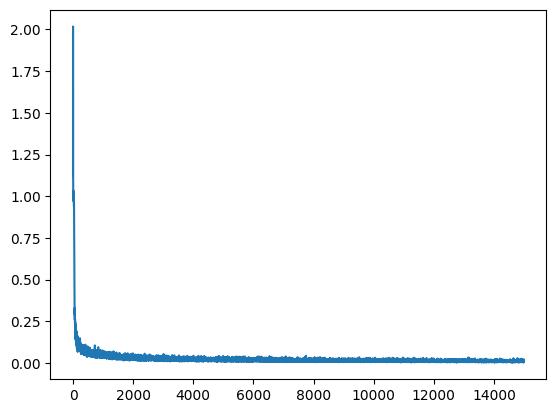

In [25]:
plt.plot(losses) 

In [ ]:
# policy.save_pretrained(savepath)

In [29]:
# pretrained_policy_path = Path("/home/ns1254/lerobot/examples/outputs/train/example_lift_diffusion_2024-11-10_23-07/checkpoint_15000.pt")
# policy = DiffusionPolicy.from_pretrained(pretrained_policy_path)
# policy.eval()
# policy.to(device)
pass 

In [ ]:
# /home/ns1254/lerobot/examples/outputs/train/example_lift_diffusion_2024-11-10_23-07/model.safetensors
# /home/ns1254/lerobot/examples/outputs/train/example_lift_diffusion_2024-11-10_23-07/checkpoint_15000.pt/model.safetensors

### offline evaluation

In [26]:
demo_id=0
rows=[]
for i in range(len(dataset)):
    row=dataset[i]
    if row['episode_index'].numpy()!=demo_id:
        break 
    rows.append(row)

for i in range(len(rows)):
    assert i==rows[i]['frame_index'].numpy()

len(rows)

54

In [27]:
actions_org=[]
for row in rows:
    actions_org.append(row['action'][0].numpy())

actions_org=np.array(actions_org)
actions_org.shape

(54, 7)

In [28]:
action_pred=[]
for row in rows:
    input_batch = {k: v.to(device) for k, v in row.items() if k in input_shapes} 
    output_dict = policy.select_action(input_batch)
    action_pred.append(output_dict[0].cpu().numpy())

In [29]:
action_pred=np.array(action_pred)
action_pred.shape

(54, 7)

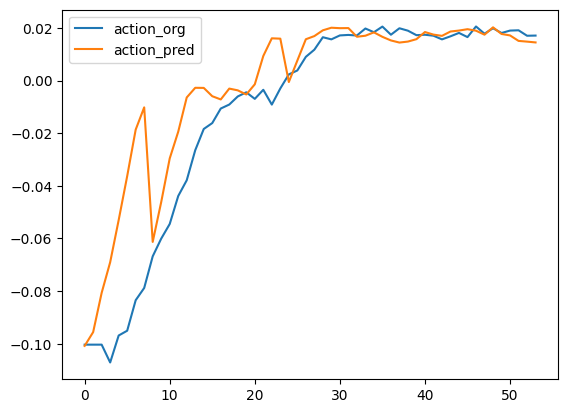

In [30]:
plt.plot(actions_org[:, 0], label="action_org")
plt.plot(action_pred[:, 0], label="action_pred")
plt.legend()

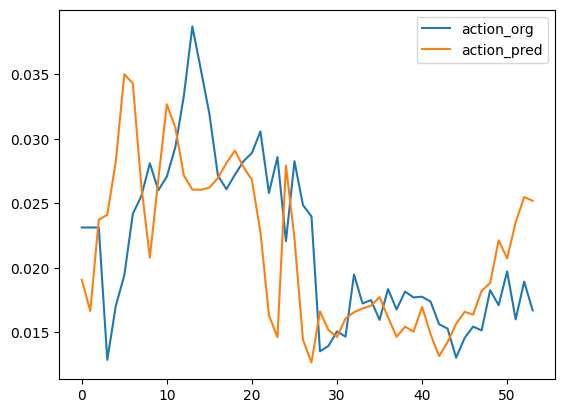

In [31]:
plt.plot(actions_org[:, 1], label="action_org")
plt.plot(action_pred[:, 1], label="action_pred")
plt.legend()

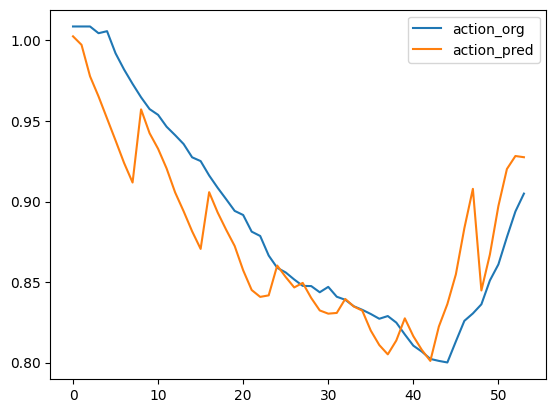

In [32]:
plt.plot(actions_org[:, 2], label="action_org")
plt.plot(action_pred[:, 2], label="action_pred")
plt.legend()

In [99]:
cfg.output_normalization_modes

{'action': 'min_max'}

In [94]:
output_dict.shape

torch.Size([2, 7])

In [ ]:
actions = policy.unnormalize_outputs(output_dict) 

In [102]:
action_stats=dataset.stats['action']
action_min=action_stats['min']
action_max=action_stats['max']
action_min, action_max

(tensor([-0.1071, -0.0466,  0.7865, -2.1443, -2.7041, -0.2459, -1.0000]),
 tensor([0.0519, 0.0535, 1.0179, 2.5630, 2.7912, 0.3027, 1.0000]))

### load pretrained

In [12]:
device = torch.device("cuda")

In [2]:
pretrained_policy_path=Path("/home/ns1254/lerobot/examples/outputs/train/example_lift_diffusion_2024-11-11_06-03/checkpoint_15000.pt/")

In [14]:
policy = DiffusionPolicy.from_pretrained(pretrained_policy_path)
policy.eval()
policy.to(device)
pass

Loading weights from local directory


In [ ]:
# Set up the dataset.
delta_timestamps = {
    # Load the previous image and state at -0.1 seconds before current frame,
    # then load current image and state corresponding to 0.0 second.
    "observation.images.agentview_image": [-0.1, 0.0],
    "observation.images.robot0_eye_in_hand_image": [-0.1, 0.0],
    "observation.robot0_eef_pos": [-0.1, 0.0],
    "observation.robot0_eef_quat": [-0.1, 0.0],
    "observation.robot0_gripper_qpos": [-0.1, 0.0],
    "observation.state": [-0.1, 0.0],
    # Load the previous action (-0.1), the next action to be executed (0.0),
    # and 14 future actions with a 0.1 seconds spacing. All these actions will be
    # used to supervise the policy.
    "action": [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
}
# dataset = LeRobotDataset("lerobot/pusht", delta_timestamps=delta_timestamps)

In [ ]:
local_dir = Path("/home/ns1254/lerobot/data") 
dataset = LeRobotDataset(repo_id="lift", root=local_dir, delta_timestamps=delta_timestamps)

In [7]:
demo_id=0
rows=[]
for i in range(len(dataset)):
    row=dataset[i]
    if row['episode_index'].numpy()!=demo_id:
        break 
    rows.append(row)

for i in range(len(rows)):
    assert i==rows[i]['frame_index'].numpy()

len(rows)

54

In [8]:
actions_org=[]
for row in rows:
    actions_org.append(row['action'][0].numpy())

actions_org=np.array(actions_org)
actions_org.shape

(54, 7)

In [10]:
input_shapes = {'observation.images.agentview_image': (3, 84, 84), 'observation.images.robot0_eye_in_hand_image': (3, 84, 84), 
                'observation.robot0_eef_pos': (3,), 'observation.robot0_eef_quat': (4,), 'observation.robot0_gripper_qpos': (2,),
                'observation.state': (32,)}

output_shapes = {'action': (7,)}

In [15]:
action_pred=[]
for row in rows:
    input_batch = {k: v.to(device) for k, v in row.items() if k in input_shapes} 
    output_dict = policy.select_action(input_batch)
    action_pred.append(output_dict[0].cpu().numpy())

In [16]:
action_pred=np.array(action_pred)
action_pred.shape

(54, 7)

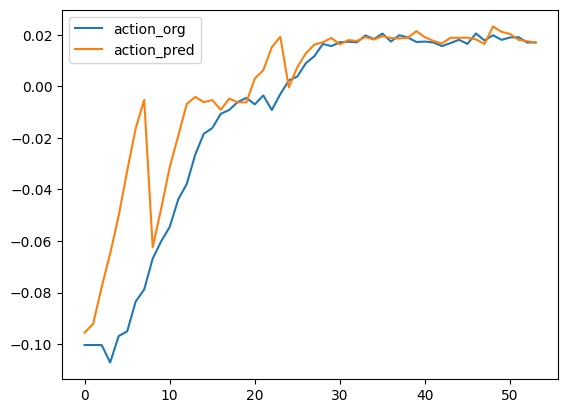

In [17]:
plt.plot(actions_org[:, 0], label="action_org")
plt.plot(action_pred[:, 0], label="action_pred")
plt.legend()

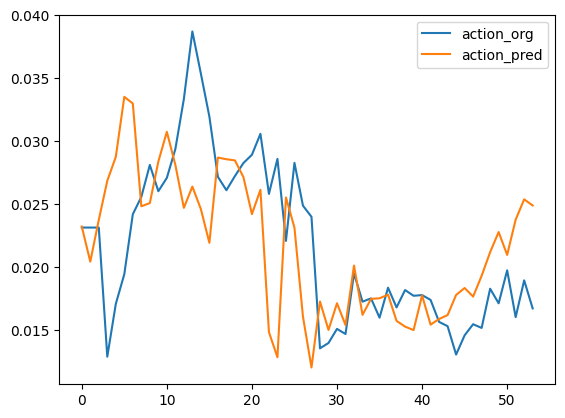

In [18]:
plt.plot(actions_org[:, 1], label="action_org")
plt.plot(action_pred[:, 1], label="action_pred")
plt.legend()

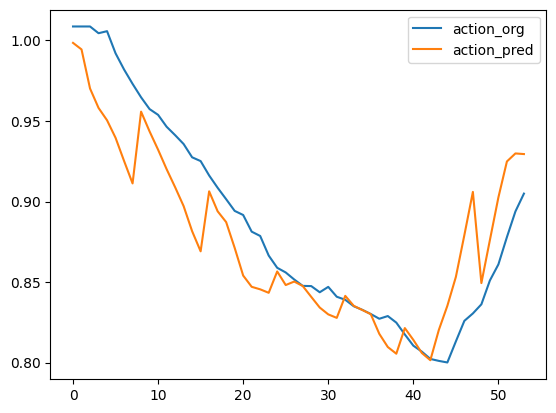

In [19]:
plt.plot(actions_org[:, 2], label="action_org")
plt.plot(action_pred[:, 2], label="action_pred")
plt.legend()